<a href="https://colab.research.google.com/github/otausendschoen/Image_Classification_Diffusion-Augmentation/blob/main/03_10%25Synthetic_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.3/509.3 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.2
    Uninstalling huggingface-hub-0.31.2:
      Successfully uninstalled huggingface-hub-0.31.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency co

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms, models
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
from collections import Counter, defaultdict
from torchvision.datasets import ImageFolder
import pandas as pd
import seaborn as sns
import zipfile

In [3]:
## Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set random seeds for reproducibility
random.seed(8)
np.random.seed(8)
torch.manual_seed(8)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(8)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Loading the dataset

Changed this to the EuroSAT ds available on hugging face dataset to save loading time.

In [5]:
# Load the EuroSAT dataset directly from Hugging Face
print("Loading dataset...")
dataset = load_dataset("jonathan-roberts1/EuroSAT")
print(dataset)

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

(…)-00000-of-00001-26e80b6de2d4dca7.parquet:   0%|          | 0.00/88.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})


In [6]:
# Create train-validation split
train_val_dataset = dataset["train"]
train_indices, val_indices = train_test_split(
    range(len(train_val_dataset)),
    test_size=0.2,
    stratify=[item['label'] for item in train_val_dataset],
    random_state=8
)

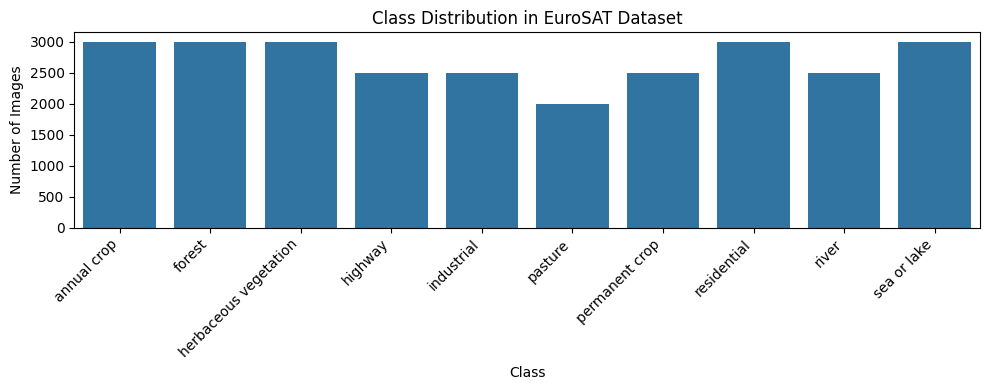

Class Percentage  Number of Images
0            annual crop     11.11%              3000
1                 forest     11.11%              3000
2  herbaceous vegetation     11.11%              3000
3                highway      9.26%              2500
4             industrial      9.26%              2500
5                pasture      7.41%              2000
6         permanent crop      9.26%              2500
7            residential     11.11%              3000
8                  river      9.26%              2500
9            sea or lake     11.11%              3000

In [7]:
# Checking Ratios

from collections import Counter
import pandas as pd

# Count labels
labels = dataset["train"]["label"]
label_names = dataset["train"].features["label"].names
label_counts = Counter(labels)

# Build DataFrame for display
total = sum(label_counts.values())
df = pd.DataFrame([
    {"Class": label_names[i],
     "Percentage": f"{(count / total) * 100:.2f}%",
     "Number of Images": count}
    for i, count in sorted(label_counts.items())
])

# Display as a table
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.barplot(data=df, x="Class", y="Number of Images")
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution in EuroSAT Dataset")
plt.tight_layout()
plt.show()

# Show DataFrame
import IPython.display as disp
disp.display(df)

Images were preprocessed using a standard pipeline for transfer learning with ImageNet-pretrained models. First, the EuroSAT images were resized from their native 64×64 resolution to 224×224 pixels to match the input requirements of the Wide ResNet50 architecture. The pixel values were then converted to tensors and normalized using ImageNet's channel-wise mean (0.485, 0.456, 0.406) and standard deviation (0.229, 0.224, 0.225) to ensure compatibility with the pretrained weights. This preprocessing approach is critical when leveraging transfer learning, as it aligns the input distribution with what the pretrained network expects, allowing effective feature extraction from the early convolutional layers despite the domain shift between natural images and satellite imagery.

In [8]:
# Function to visualize class distribution
def plot_class_distribution(labels, title, label_names=None):
    if label_names is None:
        label_names = dataset["train"].features["label"].names

    # Count and build DataFrame
    label_counts = Counter(labels)
    total = sum(label_counts.values())
    df = pd.DataFrame([
        {
            "Class": label_names[i] if isinstance(i, int) else i,
            "Percentage": f"{(count / total) * 100:.2f}%",
            "Number of Images": count
        }
        for i, count in sorted(label_counts.items())
    ])

    # Plot bar chart
    plt.figure(figsize=(10, 4))
    sns.barplot(data=df, x="Class", y="Number of Images")
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Display the table
    return df

We define the ResNet-18 model

In [9]:
# Define the ResNet-18 model
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(ResNet18Classifier, self).__init__()

        # For newer PyTorch versions (1.13+)
        try:
            self.model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        except:
            # Fallback for older versions
            self.model = models.resnet18(pretrained=pretrained)

        # Replacing the final fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In our implementation, we created a custom EuroSATDataset class that inherits from PyTorch's Dataset, providing an efficient interface between our raw satellite imagery and the training pipeline. This class handles the application of image transformations and maintains the train-validation split through indexing, allowing flexible access to different subsets of the data. We then instantiated separate training and validation datasets with their respective transformations, and wrapped them in DataLoaders with a batch size of 32. The training loader incorporates shuffling to improve model generalization, while the validation loader maintains deterministic ordering. This approach enables efficient batched processing and parallelized data loading, which is essential for training deep convolutional networks like Wide ResNet50 on large image datasets.

In [10]:
# Create PyTorch datasets
class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices=None, transform=None):
        self.dataset = dataset
        self.indices = indices if indices is not None else range(len(dataset))
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.dataset[self.indices[idx]]
        image = sample['image']
        label = sample['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

In [12]:
# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

Our implementation establishes a comprehensive training framework with integrated early stopping to prevent overfitting on the EuroSAT dataset. The training loop executes up to 30 epochs, with patience set to 5 epochs for early termination if validation accuracy fails to improve. Within each epoch, we conduct a full training pass using our train_one_epoch function, followed by validation with the validate function, while systematically applying learning rate adjustments via the cosine annealing scheduler. Performance metrics including loss, accuracy, and F1-score are tracked for both training and validation sets and stored in a history dictionary for subsequent analysis. We save the model weights only when validation accuracy improves, maintaining the best-performing configuration throughout training.

In [13]:
# Training loop function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=30, patience=7, save_path=None):
    best_val_acc = 0
    counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Print statistics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if save_path:
                torch.save(model.state_dict(), save_path)
            counter = 0
        else:
            counter += 1

        # Early stopping
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print best validation accuracy
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    return history, best_val_acc

In [14]:
# Function to create dataset with specific synthetic data ratio
def create_synthetic_dataset(train_dataset, synthetic_full, synth_prop, seed=8):
    random.seed(seed)

    # Get all original labels
    orig_labels = [label for _, label in train_dataset]
    orig_counts = Counter(orig_labels)

    # Build a map class_id -> list of synthetic indices
    class_to_syn_idxs = defaultdict(list)
    for idx, (_, lbl) in enumerate(synthetic_full):
        class_to_syn_idxs[lbl].append(idx)

    # For each class, sample synth_prop of the original count from synthetic pool
    syn_sample_idxs = []
    for cls, cnt in orig_counts.items():
        num_to_add = int(synth_prop * cnt)
        available = class_to_syn_idxs[cls]
        if len(available) < num_to_add:
            num_to_add = len(available)
        syn_sample_idxs += random.sample(available, num_to_add)

    # Create a Subset of synthetic data
    synthetic_subset = Subset(synthetic_full, syn_sample_idxs)

    # Combine original train + synthetic subset
    combined_train = ConcatDataset([train_dataset, synthetic_subset])

    print(f" → Original train samples: {len(train_dataset)}")
    print(f" → Synthetic added:       {len(synthetic_subset)}")
    print(f" → Total combined:        {len(combined_train)}")

    return combined_train

Below the full training loop for all configurations

- Using the full EuroSAT dataset:
  - No change
  - Geometric augmentation
  - 5% Synth
  - 10% Synth
  - 20% Synth
  - 30% Synth
  - 40% Synth
  - 50% Synth

Extracting synthetic dataset...
Extraction complete.

Running experiment: No Augmentation


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


Epoch 1/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1908, Train Acc: 0.9402, Train F1: 0.9401
Val Loss: 0.0859, Val Acc: 0.9720, Val F1: 0.9720
Epoch 2/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0558, Train Acc: 0.9817, Train F1: 0.9817
Val Loss: 0.0896, Val Acc: 0.9724, Val F1: 0.9724
Epoch 3/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0394, Train Acc: 0.9871, Train F1: 0.9871
Val Loss: 0.0803, Val Acc: 0.9754, Val F1: 0.9753
Epoch 4/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0233, Train Acc: 0.9926, Train F1: 0.9926
Val Loss: 0.0837, Val Acc: 0.9748, Val F1: 0.9748
Epoch 5/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0177, Train Acc: 0.9944, Train F1: 0.9944
Val Loss: 0.0976, Val Acc: 0.9709, Val F1: 0.9707
Epoch 6/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0123, Train Acc: 0.9965, Train F1: 0.9965
Val Loss: 0.0699, Val Acc: 0.9778, Val F1: 0.9777
Epoch 7/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0069, Train Acc: 0.9983, Train F1: 0.9983
Val Loss: 0.0535, Val Acc: 0.9839, Val F1: 0.9839
Epoch 8/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0071, Train Acc: 0.9981, Train F1: 0.9981
Val Loss: 0.0731, Val Acc: 0.9791, Val F1: 0.9791
Epoch 9/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0059, Train Acc: 0.9983, Train F1: 0.9983
Val Loss: 0.0568, Val Acc: 0.9833, Val F1: 0.9834
Epoch 10/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9994
Val Loss: 0.0723, Val Acc: 0.9793, Val F1: 0.9792
Epoch 11/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0542, Val Acc: 0.9856, Val F1: 0.9856
Epoch 12/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0537, Val Acc: 0.9848, Val F1: 0.9848
Epoch 13/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0571, Val Acc: 0.9846, Val F1: 0.9846
Epoch 14/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0495, Val Acc: 0.9865, Val F1: 0.9865
Epoch 15/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0505, Val Acc: 0.9867, Val F1: 0.9866
Epoch 16/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0536, Val Acc: 0.9857, Val F1: 0.9857
Epoch 17/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0496, Val Acc: 0.9865, Val F1: 0.9865
Epoch 18/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0500, Val Acc: 0.9861, Val F1: 0.9861
Epoch 19/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0497, Val Acc: 0.9870, Val F1: 0.9870
Epoch 20/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0512, Val Acc: 0.9872, Val F1: 0.9872
Epoch 21/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0505, Val Acc: 0.9863, Val F1: 0.9863
Epoch 22/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0580, Val Acc: 0.9857, Val F1: 0.9857
Epoch 23/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0499, Val Acc: 0.9869, Val F1: 0.9868
Epoch 24/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0513, Val Acc: 0.9863, Val F1: 0.9863
Epoch 25/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0503, Val Acc: 0.9872, Val F1: 0.9872
Epoch 26/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0013, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0550, Val Acc: 0.9859, Val F1: 0.9859
Epoch 27/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0031, Train Acc: 0.9993, Train F1: 0.9993
Val Loss: 0.0758, Val Acc: 0.9820, Val F1: 0.9820
Early stopping at epoch 27


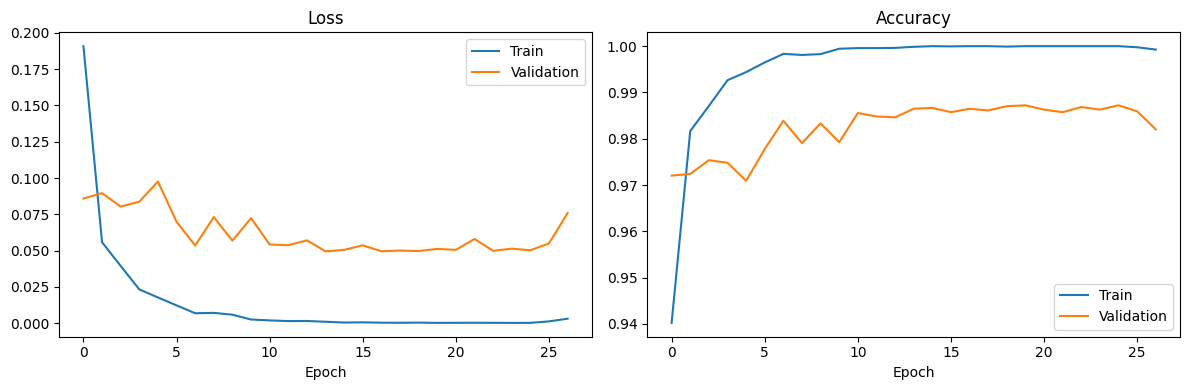

Best validation accuracy: 0.9872

Running experiment: Geometric Augmentation
Epoch 1/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2209, Train Acc: 0.9282, Train F1: 0.9281
Val Loss: 0.1063, Val Acc: 0.9656, Val F1: 0.9654
Epoch 2/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0936, Train Acc: 0.9683, Train F1: 0.9683
Val Loss: 0.0642, Val Acc: 0.9776, Val F1: 0.9776
Epoch 3/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0694, Train Acc: 0.9777, Train F1: 0.9777
Val Loss: 0.0604, Val Acc: 0.9809, Val F1: 0.9809
Epoch 4/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0661, Train Acc: 0.9778, Train F1: 0.9778
Val Loss: 0.0658, Val Acc: 0.9763, Val F1: 0.9763
Epoch 5/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0504, Train Acc: 0.9825, Train F1: 0.9825
Val Loss: 0.0593, Val Acc: 0.9824, Val F1: 0.9824
Epoch 6/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0431, Train Acc: 0.9852, Train F1: 0.9852
Val Loss: 0.0541, Val Acc: 0.9833, Val F1: 0.9833
Epoch 7/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0354, Train Acc: 0.9875, Train F1: 0.9875
Val Loss: 0.0606, Val Acc: 0.9811, Val F1: 0.9811
Epoch 8/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0306, Train Acc: 0.9901, Train F1: 0.9901
Val Loss: 0.0531, Val Acc: 0.9859, Val F1: 0.9859
Epoch 9/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0260, Train Acc: 0.9912, Train F1: 0.9912
Val Loss: 0.0418, Val Acc: 0.9887, Val F1: 0.9887
Epoch 10/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0212, Train Acc: 0.9931, Train F1: 0.9931
Val Loss: 0.0455, Val Acc: 0.9852, Val F1: 0.9852
Epoch 11/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0182, Train Acc: 0.9938, Train F1: 0.9938
Val Loss: 0.0462, Val Acc: 0.9869, Val F1: 0.9868
Epoch 12/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0107, Train Acc: 0.9974, Train F1: 0.9974
Val Loss: 0.0412, Val Acc: 0.9891, Val F1: 0.9891
Epoch 13/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0103, Train Acc: 0.9969, Train F1: 0.9969
Val Loss: 0.0438, Val Acc: 0.9885, Val F1: 0.9885
Epoch 14/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0083, Train Acc: 0.9975, Train F1: 0.9975
Val Loss: 0.0366, Val Acc: 0.9883, Val F1: 0.9883
Epoch 15/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0070, Train Acc: 0.9982, Train F1: 0.9982
Val Loss: 0.0401, Val Acc: 0.9887, Val F1: 0.9887
Epoch 16/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0066, Train Acc: 0.9985, Train F1: 0.9985
Val Loss: 0.0343, Val Acc: 0.9906, Val F1: 0.9906
Epoch 17/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0048, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0384, Val Acc: 0.9902, Val F1: 0.9902
Epoch 18/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0378, Val Acc: 0.9902, Val F1: 0.9902
Epoch 19/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0037, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0369, Val Acc: 0.9907, Val F1: 0.9907
Epoch 20/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0035, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0380, Val Acc: 0.9902, Val F1: 0.9902
Epoch 21/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0033, Train Acc: 0.9990, Train F1: 0.9990
Val Loss: 0.0401, Val Acc: 0.9900, Val F1: 0.9900
Epoch 22/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0035, Train Acc: 0.9994, Train F1: 0.9994
Val Loss: 0.0368, Val Acc: 0.9907, Val F1: 0.9907
Epoch 23/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0032, Train Acc: 0.9994, Train F1: 0.9994
Val Loss: 0.0377, Val Acc: 0.9909, Val F1: 0.9909
Epoch 24/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0030, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0372, Val Acc: 0.9902, Val F1: 0.9902
Epoch 25/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0037, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0371, Val Acc: 0.9915, Val F1: 0.9915
Epoch 26/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0058, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0418, Val Acc: 0.9909, Val F1: 0.9909
Epoch 27/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0050, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0499, Val Acc: 0.9881, Val F1: 0.9882
Epoch 28/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0082, Train Acc: 0.9973, Train F1: 0.9973
Val Loss: 0.0474, Val Acc: 0.9881, Val F1: 0.9881
Epoch 29/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0092, Train Acc: 0.9966, Train F1: 0.9966
Val Loss: 0.0497, Val Acc: 0.9869, Val F1: 0.9868
Epoch 30/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0125, Train Acc: 0.9958, Train F1: 0.9958
Val Loss: 0.0503, Val Acc: 0.9859, Val F1: 0.9859


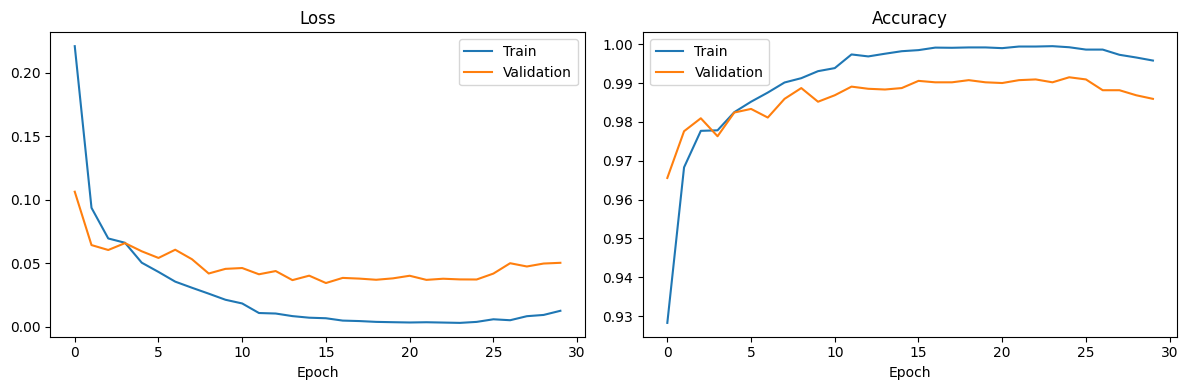

Best validation accuracy: 0.9915

Running experiment: 5% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       1080
 → Total combined:        22680


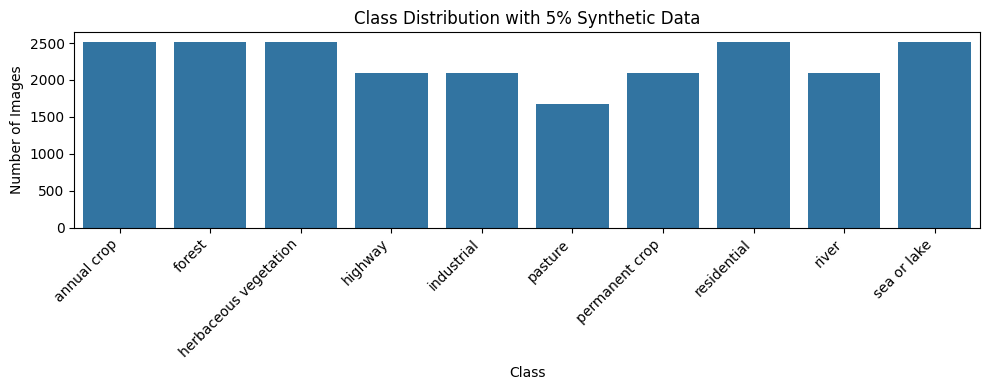

                   Class Percentage  Number of Images
0            annual crop     11.11%              2520
1                 forest     11.11%              2520
2  herbaceous vegetation     11.11%              2520
3                highway      9.26%              2100
4             industrial      9.26%              2100
5                pasture      7.41%              1680
6         permanent crop      9.26%              2100
7            residential     11.11%              2520
8                  river      9.26%              2100
9            sea or lake     11.11%              2520
Epoch 1/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2285, Train Acc: 0.9283, Train F1: 0.9281
Val Loss: 0.0853, Val Acc: 0.9730, Val F1: 0.9730
Epoch 2/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0807, Train Acc: 0.9729, Train F1: 0.9729
Val Loss: 0.0650, Val Acc: 0.9781, Val F1: 0.9781
Epoch 3/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0448, Train Acc: 0.9859, Train F1: 0.9859
Val Loss: 0.0841, Val Acc: 0.9739, Val F1: 0.9739
Epoch 4/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0245, Train Acc: 0.9922, Train F1: 0.9922
Val Loss: 0.0669, Val Acc: 0.9793, Val F1: 0.9792
Epoch 5/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0199, Train Acc: 0.9936, Train F1: 0.9936
Val Loss: 0.0801, Val Acc: 0.9767, Val F1: 0.9767
Epoch 6/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0155, Train Acc: 0.9952, Train F1: 0.9952
Val Loss: 0.0696, Val Acc: 0.9785, Val F1: 0.9786
Epoch 7/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0118, Train Acc: 0.9968, Train F1: 0.9968
Val Loss: 0.0552, Val Acc: 0.9831, Val F1: 0.9831
Epoch 8/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0077, Train Acc: 0.9978, Train F1: 0.9978
Val Loss: 0.0621, Val Acc: 0.9820, Val F1: 0.9820
Epoch 9/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0079, Train Acc: 0.9978, Train F1: 0.9978
Val Loss: 0.0670, Val Acc: 0.9819, Val F1: 0.9818
Epoch 10/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0045, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0543, Val Acc: 0.9859, Val F1: 0.9859
Epoch 11/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0032, Train Acc: 0.9993, Train F1: 0.9993
Val Loss: 0.0577, Val Acc: 0.9841, Val F1: 0.9841
Epoch 12/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0547, Val Acc: 0.9869, Val F1: 0.9868
Epoch 13/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0548, Val Acc: 0.9857, Val F1: 0.9857
Epoch 14/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0605, Val Acc: 0.9848, Val F1: 0.9848
Epoch 15/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0529, Val Acc: 0.9861, Val F1: 0.9861
Epoch 16/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0550, Val Acc: 0.9857, Val F1: 0.9857
Epoch 17/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0515, Val Acc: 0.9863, Val F1: 0.9863
Epoch 18/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0533, Val Acc: 0.9850, Val F1: 0.9850
Epoch 19/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0506, Val Acc: 0.9865, Val F1: 0.9865
Early stopping at epoch 19


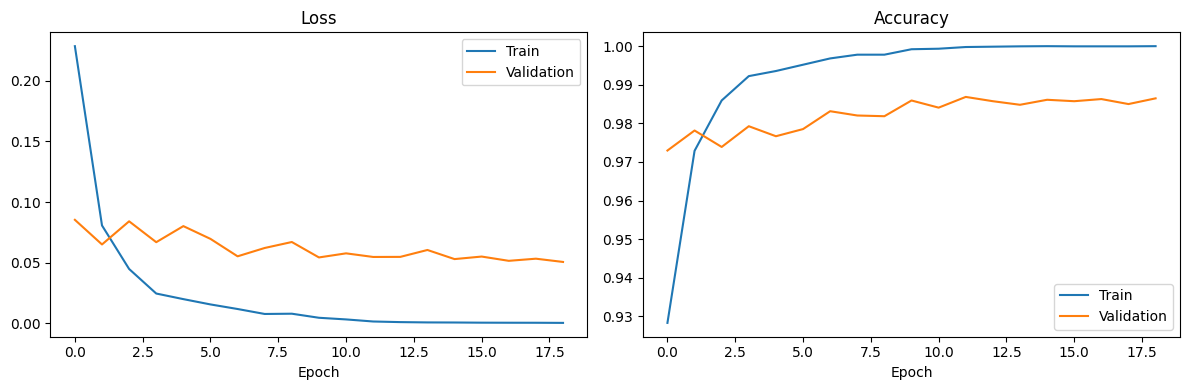

Best validation accuracy: 0.9869

Running experiment: 10% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       2160
 → Total combined:        23760


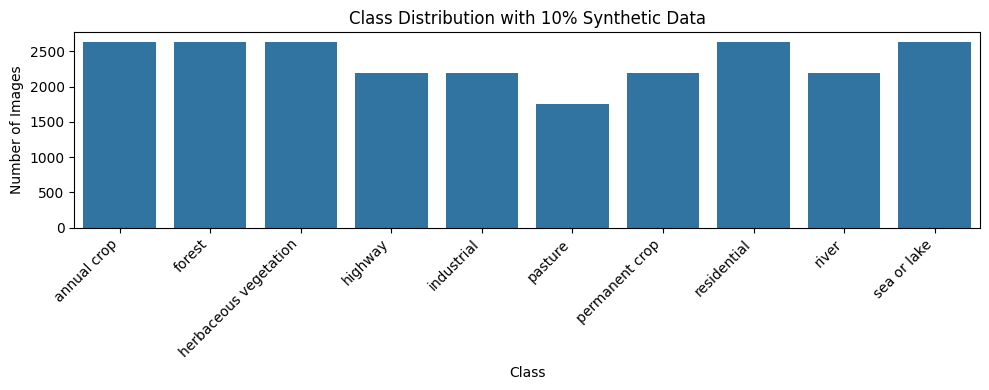

                   Class Percentage  Number of Images
0            annual crop     11.11%              2640
1                 forest     11.11%              2640
2  herbaceous vegetation     11.11%              2640
3                highway      9.26%              2200
4             industrial      9.26%              2200
5                pasture      7.41%              1760
6         permanent crop      9.26%              2200
7            residential     11.11%              2640
8                  river      9.26%              2200
9            sea or lake     11.11%              2640
Epoch 1/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2359, Train Acc: 0.9250, Train F1: 0.9248
Val Loss: 0.1352, Val Acc: 0.9550, Val F1: 0.9549
Epoch 2/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0794, Train Acc: 0.9734, Train F1: 0.9734
Val Loss: 0.0679, Val Acc: 0.9759, Val F1: 0.9759
Epoch 3/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0472, Train Acc: 0.9850, Train F1: 0.9850
Val Loss: 0.1119, Val Acc: 0.9661, Val F1: 0.9659
Epoch 4/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0312, Train Acc: 0.9905, Train F1: 0.9905
Val Loss: 0.0682, Val Acc: 0.9794, Val F1: 0.9795
Epoch 5/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0199, Train Acc: 0.9944, Train F1: 0.9944
Val Loss: 0.0770, Val Acc: 0.9787, Val F1: 0.9787
Epoch 6/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0133, Train Acc: 0.9965, Train F1: 0.9965
Val Loss: 0.0810, Val Acc: 0.9765, Val F1: 0.9765
Epoch 7/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0104, Train Acc: 0.9971, Train F1: 0.9971
Val Loss: 0.0598, Val Acc: 0.9824, Val F1: 0.9824
Epoch 8/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0122, Train Acc: 0.9966, Train F1: 0.9966
Val Loss: 0.0618, Val Acc: 0.9819, Val F1: 0.9818
Epoch 9/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0090, Train Acc: 0.9977, Train F1: 0.9977
Val Loss: 0.0629, Val Acc: 0.9824, Val F1: 0.9824
Epoch 10/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0050, Train Acc: 0.9987, Train F1: 0.9987
Val Loss: 0.0592, Val Acc: 0.9826, Val F1: 0.9826
Epoch 11/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0041, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0576, Val Acc: 0.9861, Val F1: 0.9861
Epoch 12/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0014, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0572, Val Acc: 0.9854, Val F1: 0.9854
Epoch 13/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0549, Val Acc: 0.9870, Val F1: 0.9870
Epoch 14/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0528, Val Acc: 0.9865, Val F1: 0.9865
Epoch 15/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0555, Val Acc: 0.9859, Val F1: 0.9859
Epoch 16/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0542, Val Acc: 0.9867, Val F1: 0.9867
Epoch 17/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0539, Val Acc: 0.9874, Val F1: 0.9874
Epoch 18/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0535, Val Acc: 0.9867, Val F1: 0.9867
Epoch 19/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0557, Val Acc: 0.9859, Val F1: 0.9859
Epoch 20/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0524, Val Acc: 0.9878, Val F1: 0.9878
Epoch 21/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0523, Val Acc: 0.9867, Val F1: 0.9867
Epoch 22/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0520, Val Acc: 0.9867, Val F1: 0.9867
Epoch 23/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0523, Val Acc: 0.9865, Val F1: 0.9865
Epoch 24/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0524, Val Acc: 0.9859, Val F1: 0.9859
Epoch 25/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0579, Val Acc: 0.9856, Val F1: 0.9855
Epoch 26/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0576, Val Acc: 0.9846, Val F1: 0.9846
Epoch 27/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0014, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0578, Val Acc: 0.9837, Val F1: 0.9837
Early stopping at epoch 27


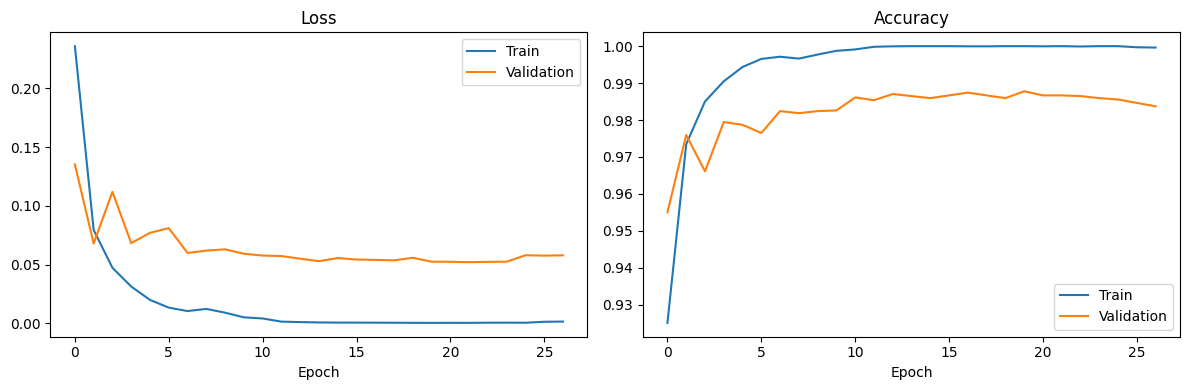

Best validation accuracy: 0.9878

Running experiment: 20% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       4320
 → Total combined:        25920


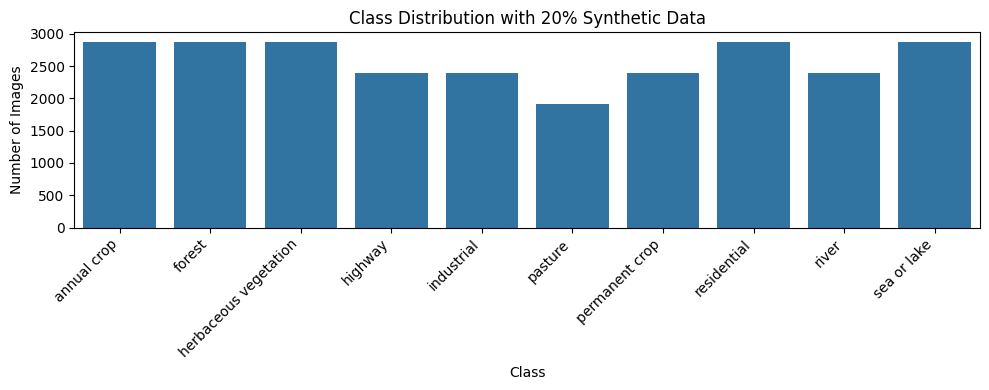

                   Class Percentage  Number of Images
0            annual crop     11.11%              2880
1                 forest     11.11%              2880
2  herbaceous vegetation     11.11%              2880
3                highway      9.26%              2400
4             industrial      9.26%              2400
5                pasture      7.41%              1920
6         permanent crop      9.26%              2400
7            residential     11.11%              2880
8                  river      9.26%              2400
9            sea or lake     11.11%              2880
Epoch 1/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2491, Train Acc: 0.9205, Train F1: 0.9203
Val Loss: 0.0753, Val Acc: 0.9744, Val F1: 0.9744
Epoch 2/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0928, Train Acc: 0.9692, Train F1: 0.9692
Val Loss: 0.0709, Val Acc: 0.9767, Val F1: 0.9766
Epoch 3/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0490, Train Acc: 0.9846, Train F1: 0.9846
Val Loss: 0.0648, Val Acc: 0.9785, Val F1: 0.9785
Epoch 4/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0336, Train Acc: 0.9890, Train F1: 0.9890
Val Loss: 0.0818, Val Acc: 0.9728, Val F1: 0.9728
Epoch 5/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0217, Train Acc: 0.9934, Train F1: 0.9934
Val Loss: 0.0857, Val Acc: 0.9744, Val F1: 0.9744
Epoch 6/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0170, Train Acc: 0.9947, Train F1: 0.9947
Val Loss: 0.0716, Val Acc: 0.9796, Val F1: 0.9796
Epoch 7/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0117, Train Acc: 0.9966, Train F1: 0.9966
Val Loss: 0.0628, Val Acc: 0.9830, Val F1: 0.9829
Epoch 8/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0079, Train Acc: 0.9979, Train F1: 0.9979
Val Loss: 0.0632, Val Acc: 0.9822, Val F1: 0.9822
Epoch 9/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0114, Train Acc: 0.9969, Train F1: 0.9969
Val Loss: 0.0645, Val Acc: 0.9811, Val F1: 0.9811
Epoch 10/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0059, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0593, Val Acc: 0.9835, Val F1: 0.9835
Epoch 11/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9994
Val Loss: 0.0562, Val Acc: 0.9848, Val F1: 0.9848
Epoch 12/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0035, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0589, Val Acc: 0.9848, Val F1: 0.9848
Epoch 13/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0577, Val Acc: 0.9835, Val F1: 0.9835
Epoch 14/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0546, Val Acc: 0.9865, Val F1: 0.9865
Epoch 15/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0541, Val Acc: 0.9863, Val F1: 0.9863
Epoch 16/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0529, Val Acc: 0.9874, Val F1: 0.9874
Epoch 17/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0504, Val Acc: 0.9874, Val F1: 0.9874
Epoch 18/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0521, Val Acc: 0.9863, Val F1: 0.9863
Epoch 19/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0536, Val Acc: 0.9874, Val F1: 0.9874
Epoch 20/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0511, Val Acc: 0.9869, Val F1: 0.9868
Epoch 21/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0504, Val Acc: 0.9876, Val F1: 0.9876
Epoch 22/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0510, Val Acc: 0.9880, Val F1: 0.9880
Epoch 23/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0511, Val Acc: 0.9878, Val F1: 0.9878
Epoch 24/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0527, Val Acc: 0.9881, Val F1: 0.9881
Epoch 25/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0545, Val Acc: 0.9861, Val F1: 0.9861
Epoch 26/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0553, Val Acc: 0.9863, Val F1: 0.9863
Epoch 27/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0029, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0630, Val Acc: 0.9833, Val F1: 0.9833
Epoch 28/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0025, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0707, Val Acc: 0.9817, Val F1: 0.9817
Epoch 29/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0058, Train Acc: 0.9984, Train F1: 0.9984
Val Loss: 0.0707, Val Acc: 0.9815, Val F1: 0.9815
Epoch 30/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0066, Train Acc: 0.9981, Train F1: 0.9981
Val Loss: 0.0946, Val Acc: 0.9785, Val F1: 0.9785


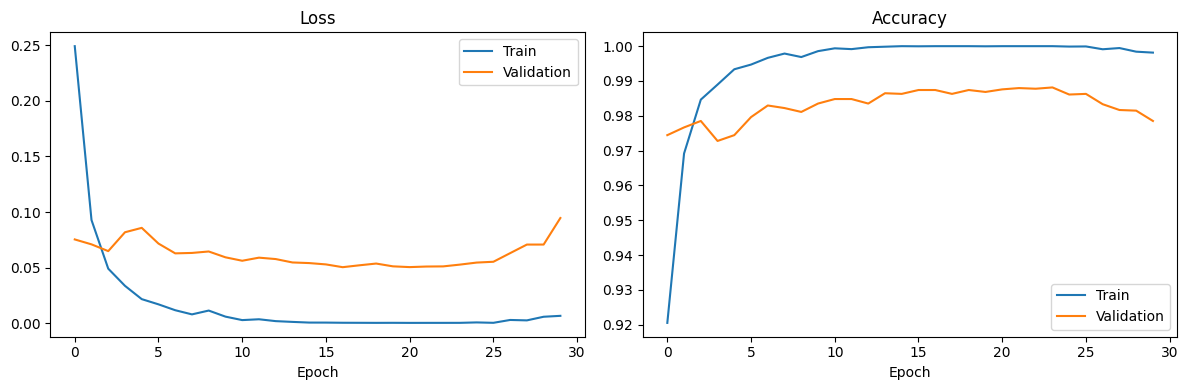

Best validation accuracy: 0.9881

Running experiment: 30% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       6480
 → Total combined:        28080


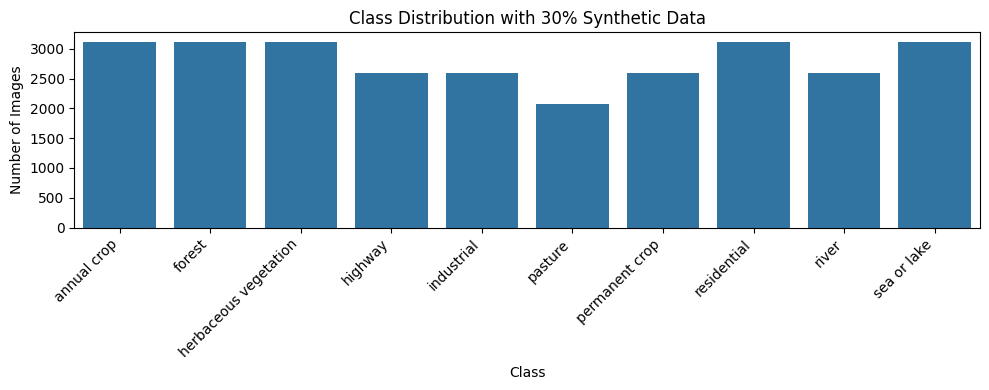

                   Class Percentage  Number of Images
0            annual crop     11.11%              3120
1                 forest     11.11%              3120
2  herbaceous vegetation     11.11%              3120
3                highway      9.26%              2600
4             industrial      9.26%              2600
5                pasture      7.41%              2080
6         permanent crop      9.26%              2600
7            residential     11.11%              3120
8                  river      9.26%              2600
9            sea or lake     11.11%              3120
Epoch 1/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2547, Train Acc: 0.9176, Train F1: 0.9176
Val Loss: 0.0862, Val Acc: 0.9706, Val F1: 0.9706
Epoch 2/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1013, Train Acc: 0.9657, Train F1: 0.9657
Val Loss: 0.0743, Val Acc: 0.9737, Val F1: 0.9737
Epoch 3/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0593, Train Acc: 0.9813, Train F1: 0.9813
Val Loss: 0.0764, Val Acc: 0.9746, Val F1: 0.9747
Epoch 4/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0357, Train Acc: 0.9884, Train F1: 0.9884
Val Loss: 0.0683, Val Acc: 0.9780, Val F1: 0.9780
Epoch 5/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0224, Train Acc: 0.9936, Train F1: 0.9936
Val Loss: 0.0870, Val Acc: 0.9730, Val F1: 0.9730
Epoch 6/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0205, Train Acc: 0.9934, Train F1: 0.9934
Val Loss: 0.0855, Val Acc: 0.9756, Val F1: 0.9757
Epoch 7/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0146, Train Acc: 0.9956, Train F1: 0.9956
Val Loss: 0.0709, Val Acc: 0.9807, Val F1: 0.9807
Epoch 8/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0089, Train Acc: 0.9976, Train F1: 0.9976
Val Loss: 0.0603, Val Acc: 0.9839, Val F1: 0.9839
Epoch 9/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0101, Train Acc: 0.9968, Train F1: 0.9968
Val Loss: 0.0766, Val Acc: 0.9787, Val F1: 0.9787
Epoch 10/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0050, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0607, Val Acc: 0.9852, Val F1: 0.9852
Epoch 11/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0038, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0633, Val Acc: 0.9800, Val F1: 0.9800
Epoch 12/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0025, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0528, Val Acc: 0.9843, Val F1: 0.9842
Epoch 13/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0545, Val Acc: 0.9844, Val F1: 0.9844
Epoch 14/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0535, Val Acc: 0.9850, Val F1: 0.9850
Epoch 15/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0519, Val Acc: 0.9865, Val F1: 0.9865
Epoch 16/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0517, Val Acc: 0.9870, Val F1: 0.9870
Epoch 17/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0486, Val Acc: 0.9872, Val F1: 0.9872
Epoch 18/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0482, Val Acc: 0.9883, Val F1: 0.9883
Epoch 19/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0496, Val Acc: 0.9874, Val F1: 0.9874
Epoch 20/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0502, Val Acc: 0.9869, Val F1: 0.9868
Epoch 21/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0489, Val Acc: 0.9867, Val F1: 0.9867
Epoch 22/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0531, Val Acc: 0.9857, Val F1: 0.9857
Epoch 23/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0505, Val Acc: 0.9865, Val F1: 0.9865
Epoch 24/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0536, Val Acc: 0.9861, Val F1: 0.9861
Epoch 25/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0572, Val Acc: 0.9850, Val F1: 0.9850
Early stopping at epoch 25


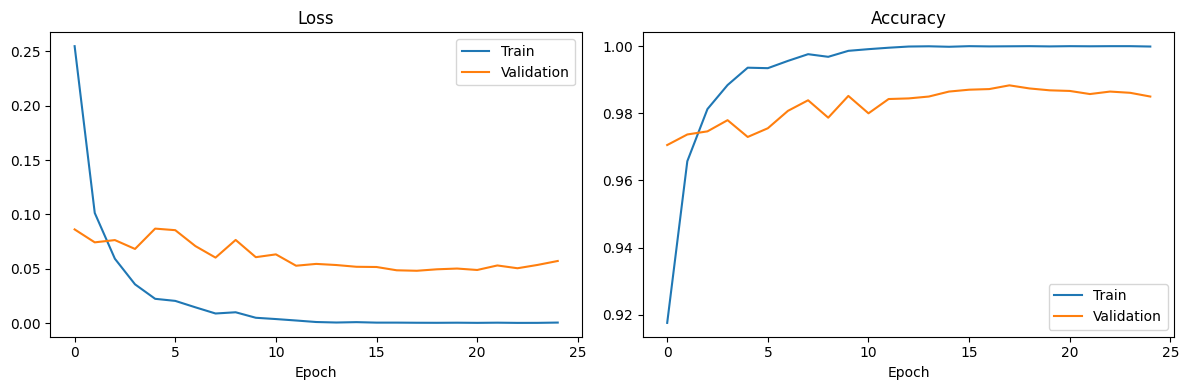

Best validation accuracy: 0.9883

Running experiment: 40% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       8640
 → Total combined:        30240


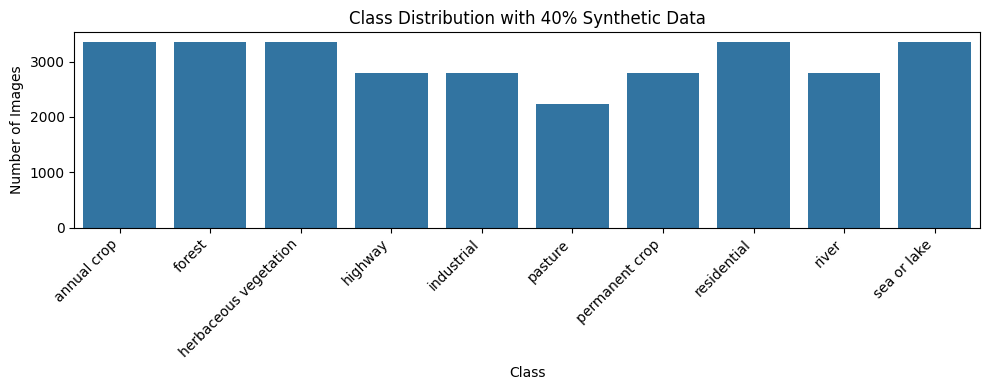

                   Class Percentage  Number of Images
0            annual crop     11.11%              3360
1                 forest     11.11%              3360
2  herbaceous vegetation     11.11%              3360
3                highway      9.26%              2800
4             industrial      9.26%              2800
5                pasture      7.41%              2240
6         permanent crop      9.26%              2800
7            residential     11.11%              3360
8                  river      9.26%              2800
9            sea or lake     11.11%              3360
Epoch 1/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2605, Train Acc: 0.9151, Train F1: 0.9150
Val Loss: 0.1027, Val Acc: 0.9680, Val F1: 0.9679
Epoch 2/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1007, Train Acc: 0.9666, Train F1: 0.9666
Val Loss: 0.0778, Val Acc: 0.9739, Val F1: 0.9739
Epoch 3/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0574, Train Acc: 0.9805, Train F1: 0.9805
Val Loss: 0.0724, Val Acc: 0.9776, Val F1: 0.9776
Epoch 4/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0339, Train Acc: 0.9897, Train F1: 0.9897
Val Loss: 0.0757, Val Acc: 0.9772, Val F1: 0.9772
Epoch 5/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0287, Train Acc: 0.9910, Train F1: 0.9910
Val Loss: 0.1282, Val Acc: 0.9611, Val F1: 0.9611
Epoch 6/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0214, Train Acc: 0.9930, Train F1: 0.9930
Val Loss: 0.0809, Val Acc: 0.9752, Val F1: 0.9752
Epoch 7/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0143, Train Acc: 0.9960, Train F1: 0.9960
Val Loss: 0.0612, Val Acc: 0.9817, Val F1: 0.9817
Epoch 8/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0074, Train Acc: 0.9980, Train F1: 0.9980
Val Loss: 0.0755, Val Acc: 0.9772, Val F1: 0.9772
Epoch 9/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0060, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0647, Val Acc: 0.9830, Val F1: 0.9830
Epoch 10/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 0.9990, Train F1: 0.9990
Val Loss: 0.0724, Val Acc: 0.9811, Val F1: 0.9811
Epoch 11/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0059, Train Acc: 0.9984, Train F1: 0.9984
Val Loss: 0.0676, Val Acc: 0.9806, Val F1: 0.9805
Epoch 12/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0049, Train Acc: 0.9985, Train F1: 0.9985
Val Loss: 0.0632, Val Acc: 0.9828, Val F1: 0.9828
Epoch 13/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0580, Val Acc: 0.9846, Val F1: 0.9846
Epoch 14/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0554, Val Acc: 0.9865, Val F1: 0.9865
Epoch 15/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0587, Val Acc: 0.9850, Val F1: 0.9850
Epoch 16/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0547, Val Acc: 0.9857, Val F1: 0.9857
Epoch 17/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0553, Val Acc: 0.9861, Val F1: 0.9861
Epoch 18/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0553, Val Acc: 0.9872, Val F1: 0.9872
Epoch 19/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0564, Val Acc: 0.9867, Val F1: 0.9867
Epoch 20/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0540, Val Acc: 0.9867, Val F1: 0.9867
Epoch 21/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0560, Val Acc: 0.9857, Val F1: 0.9857
Epoch 22/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0538, Val Acc: 0.9859, Val F1: 0.9859
Epoch 23/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0526, Val Acc: 0.9869, Val F1: 0.9869
Epoch 24/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0580, Val Acc: 0.9861, Val F1: 0.9861
Epoch 25/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0557, Val Acc: 0.9869, Val F1: 0.9869
Early stopping at epoch 25


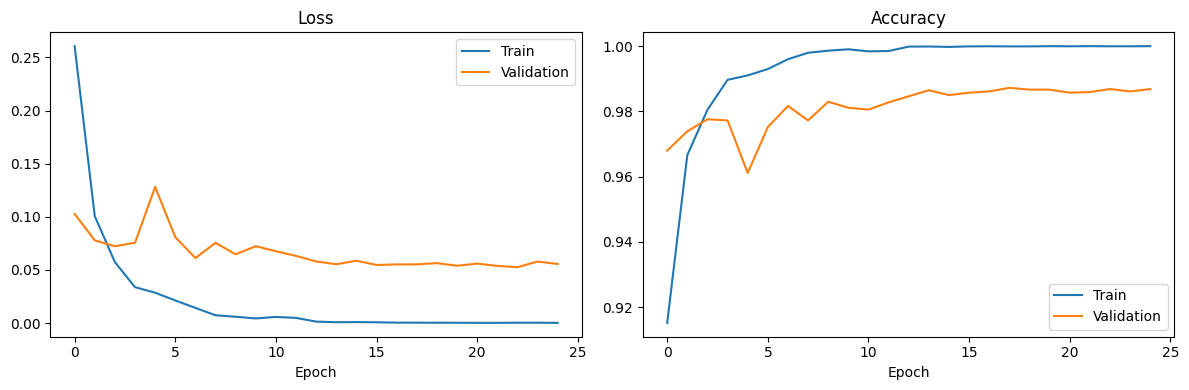

Best validation accuracy: 0.9872

Running experiment: 50% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       10800
 → Total combined:        32400


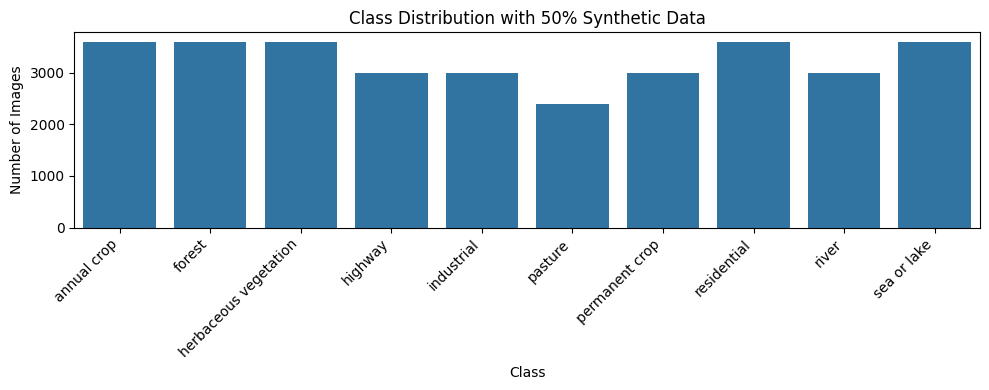

                   Class Percentage  Number of Images
0            annual crop     11.11%              3600
1                 forest     11.11%              3600
2  herbaceous vegetation     11.11%              3600
3                highway      9.26%              3000
4             industrial      9.26%              3000
5                pasture      7.41%              2400
6         permanent crop      9.26%              3000
7            residential     11.11%              3600
8                  river      9.26%              3000
9            sea or lake     11.11%              3600
Epoch 1/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2594, Train Acc: 0.9153, Train F1: 0.9152
Val Loss: 0.0813, Val Acc: 0.9746, Val F1: 0.9747
Epoch 2/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1001, Train Acc: 0.9667, Train F1: 0.9667
Val Loss: 0.1048, Val Acc: 0.9672, Val F1: 0.9672
Epoch 3/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0582, Train Acc: 0.9804, Train F1: 0.9804
Val Loss: 0.0878, Val Acc: 0.9726, Val F1: 0.9725
Epoch 4/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0385, Train Acc: 0.9877, Train F1: 0.9877
Val Loss: 0.0757, Val Acc: 0.9770, Val F1: 0.9770
Epoch 5/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0233, Train Acc: 0.9928, Train F1: 0.9928
Val Loss: 0.0899, Val Acc: 0.9730, Val F1: 0.9729
Epoch 6/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0229, Train Acc: 0.9927, Train F1: 0.9927
Val Loss: 0.0819, Val Acc: 0.9761, Val F1: 0.9761
Epoch 7/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0134, Train Acc: 0.9964, Train F1: 0.9964
Val Loss: 0.0862, Val Acc: 0.9757, Val F1: 0.9757
Epoch 8/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0123, Train Acc: 0.9958, Train F1: 0.9958
Val Loss: 0.0779, Val Acc: 0.9765, Val F1: 0.9764
Epoch 9/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0154, Train Acc: 0.9949, Train F1: 0.9949
Val Loss: 0.0681, Val Acc: 0.9815, Val F1: 0.9815
Epoch 10/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0072, Train Acc: 0.9979, Train F1: 0.9979
Val Loss: 0.0671, Val Acc: 0.9806, Val F1: 0.9805
Epoch 11/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0038, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0569, Val Acc: 0.9839, Val F1: 0.9839
Epoch 12/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0619, Val Acc: 0.9844, Val F1: 0.9844
Epoch 13/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0030, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0580, Val Acc: 0.9835, Val F1: 0.9835
Epoch 14/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0016, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0591, Val Acc: 0.9835, Val F1: 0.9835
Epoch 15/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0605, Val Acc: 0.9843, Val F1: 0.9842
Epoch 16/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0572, Val Acc: 0.9857, Val F1: 0.9857
Epoch 17/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0566, Val Acc: 0.9856, Val F1: 0.9856
Epoch 18/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0568, Val Acc: 0.9854, Val F1: 0.9854
Epoch 19/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0562, Val Acc: 0.9865, Val F1: 0.9865
Epoch 20/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0565, Val Acc: 0.9856, Val F1: 0.9855
Epoch 21/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0573, Val Acc: 0.9857, Val F1: 0.9857
Epoch 22/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0577, Val Acc: 0.9857, Val F1: 0.9857
Epoch 23/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0552, Val Acc: 0.9852, Val F1: 0.9852
Epoch 24/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0609, Val Acc: 0.9841, Val F1: 0.9841
Epoch 25/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0601, Val Acc: 0.9844, Val F1: 0.9844
Epoch 26/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0669, Val Acc: 0.9831, Val F1: 0.9831
Early stopping at epoch 26


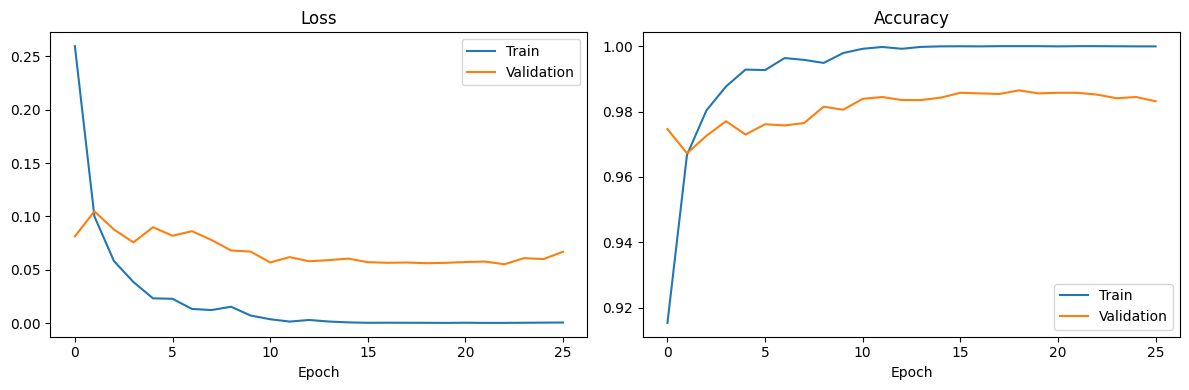

Best validation accuracy: 0.9865

Running experiment: Geometric + 30% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       6480
 → Total combined:        28080


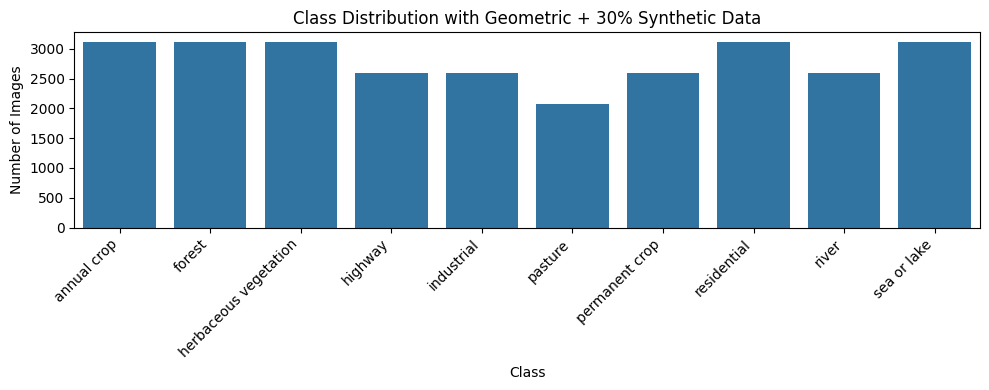

                   Class Percentage  Number of Images
0            annual crop     11.11%              3120
1                 forest     11.11%              3120
2  herbaceous vegetation     11.11%              3120
3                highway      9.26%              2600
4             industrial      9.26%              2600
5                pasture      7.41%              2080
6         permanent crop      9.26%              2600
7            residential     11.11%              3120
8                  river      9.26%              2600
9            sea or lake     11.11%              3120
Epoch 1/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2707, Train Acc: 0.9103, Train F1: 0.9102
Val Loss: 0.1080, Val Acc: 0.9663, Val F1: 0.9662
Epoch 2/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1463, Train Acc: 0.9516, Train F1: 0.9516
Val Loss: 0.1009, Val Acc: 0.9663, Val F1: 0.9664
Epoch 3/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1143, Train Acc: 0.9608, Train F1: 0.9608
Val Loss: 0.0731, Val Acc: 0.9744, Val F1: 0.9745
Epoch 4/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0966, Train Acc: 0.9673, Train F1: 0.9673
Val Loss: 0.0700, Val Acc: 0.9776, Val F1: 0.9776
Epoch 5/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0842, Train Acc: 0.9714, Train F1: 0.9714
Val Loss: 0.0608, Val Acc: 0.9830, Val F1: 0.9829
Epoch 6/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0719, Train Acc: 0.9751, Train F1: 0.9751
Val Loss: 0.0574, Val Acc: 0.9804, Val F1: 0.9804
Epoch 7/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0599, Train Acc: 0.9792, Train F1: 0.9792
Val Loss: 0.0579, Val Acc: 0.9802, Val F1: 0.9802
Epoch 8/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0504, Train Acc: 0.9828, Train F1: 0.9828
Val Loss: 0.0523, Val Acc: 0.9828, Val F1: 0.9828
Epoch 9/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0436, Train Acc: 0.9857, Train F1: 0.9857
Val Loss: 0.0489, Val Acc: 0.9856, Val F1: 0.9855
Epoch 10/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0368, Train Acc: 0.9879, Train F1: 0.9879
Val Loss: 0.0513, Val Acc: 0.9819, Val F1: 0.9819
Epoch 11/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0313, Train Acc: 0.9897, Train F1: 0.9897
Val Loss: 0.0494, Val Acc: 0.9854, Val F1: 0.9854
Epoch 12/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0243, Train Acc: 0.9923, Train F1: 0.9923
Val Loss: 0.0436, Val Acc: 0.9881, Val F1: 0.9881
Epoch 13/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0218, Train Acc: 0.9933, Train F1: 0.9933
Val Loss: 0.0501, Val Acc: 0.9856, Val F1: 0.9856
Epoch 14/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0158, Train Acc: 0.9954, Train F1: 0.9954
Val Loss: 0.0468, Val Acc: 0.9880, Val F1: 0.9880
Epoch 15/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0144, Train Acc: 0.9958, Train F1: 0.9958
Val Loss: 0.0495, Val Acc: 0.9869, Val F1: 0.9869
Epoch 16/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0115, Train Acc: 0.9965, Train F1: 0.9965
Val Loss: 0.0440, Val Acc: 0.9885, Val F1: 0.9885
Epoch 17/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0091, Train Acc: 0.9976, Train F1: 0.9976
Val Loss: 0.0436, Val Acc: 0.9874, Val F1: 0.9874
Epoch 18/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0074, Train Acc: 0.9985, Train F1: 0.9985
Val Loss: 0.0422, Val Acc: 0.9880, Val F1: 0.9880
Epoch 19/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0083, Train Acc: 0.9978, Train F1: 0.9978
Val Loss: 0.0407, Val Acc: 0.9885, Val F1: 0.9885
Epoch 20/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0069, Train Acc: 0.9983, Train F1: 0.9983
Val Loss: 0.0423, Val Acc: 0.9889, Val F1: 0.9889
Epoch 21/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0074, Train Acc: 0.9979, Train F1: 0.9979
Val Loss: 0.0441, Val Acc: 0.9885, Val F1: 0.9885
Epoch 22/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0064, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0405, Val Acc: 0.9881, Val F1: 0.9881
Epoch 23/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0066, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0426, Val Acc: 0.9881, Val F1: 0.9881
Epoch 24/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0073, Train Acc: 0.9982, Train F1: 0.9982
Val Loss: 0.0406, Val Acc: 0.9894, Val F1: 0.9894
Epoch 25/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0073, Train Acc: 0.9981, Train F1: 0.9981
Val Loss: 0.0452, Val Acc: 0.9881, Val F1: 0.9881
Epoch 26/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0085, Train Acc: 0.9974, Train F1: 0.9974
Val Loss: 0.0440, Val Acc: 0.9885, Val F1: 0.9885
Epoch 27/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0112, Train Acc: 0.9967, Train F1: 0.9967
Val Loss: 0.0490, Val Acc: 0.9869, Val F1: 0.9869
Epoch 28/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0122, Train Acc: 0.9967, Train F1: 0.9967
Val Loss: 0.0412, Val Acc: 0.9896, Val F1: 0.9896
Epoch 29/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0154, Train Acc: 0.9951, Train F1: 0.9951
Val Loss: 0.0466, Val Acc: 0.9859, Val F1: 0.9859
Epoch 30/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0196, Train Acc: 0.9934, Train F1: 0.9934
Val Loss: 0.0538, Val Acc: 0.9848, Val F1: 0.9848


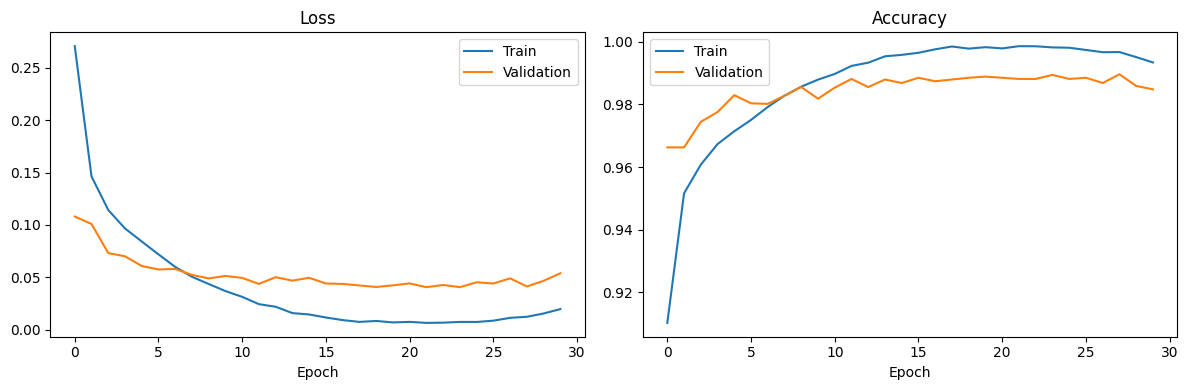

Best validation accuracy: 0.9896


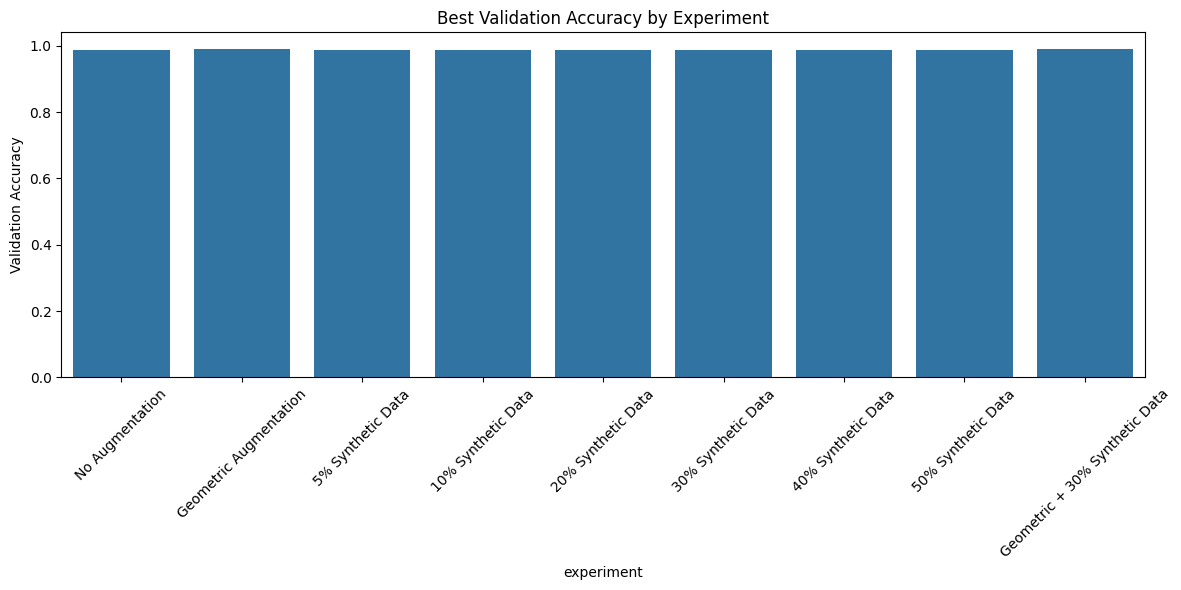

Final results:
                       experiment  best_val_acc
0                 No Augmentation      0.987222
1          Geometric Augmentation      0.991481
2               5% Synthetic Data      0.986852
3              10% Synthetic Data      0.987778
4              20% Synthetic Data      0.988148
5              30% Synthetic Data      0.988333
6              40% Synthetic Data      0.987222
7              50% Synthetic Data      0.986481
8  Geometric + 30% Synthetic Data      0.989630


In [16]:
# Main execution
def run_experiments():
    # Define transformations

    # 1. Basic transformation (no augmentation)
    transform_basic = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Geometric augmentation
    transform_geometric = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Standard test transformation (no augmentation)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create base datasets
    base_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_basic)
    geo_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_geometric)
    val_dataset = EuroSATDataset(train_val_dataset, val_indices, transform_test)

    # Create validation dataloader (common for all experiments)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    # Extract synthetic dataset
    print("Extracting synthetic dataset...")
    zip_path = "/content/drive/MyDrive/data/ddpm-generated-images.zip"
    extract_path = "/content/ddpm_generated"

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete.")
    except Exception as e:
        print(f"Error extracting synthetic dataset: {e}")
        print("Make sure the path is correct and the file exists")
        return

    # Load synthetic data with basic and geometric transformations
    synthetic_basic = ImageFolder(
        root=extract_path,
        transform=transform_basic
    )

    # Load synthetic data with geometric transformations
    synthetic_geometric = ImageFolder(
        root=extract_path,
        transform=transform_geometric
    )

    # Define different augmentation ratios
    synth_ratios = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50]

    # Store results
    all_results = {
        'experiment': [],
        'best_val_acc': []
    }

    # Run experiment with no augmentation
    print("\n=========================================")
    print("Running experiment: No Augmentation")
    print("=========================================")

    train_loader = DataLoader(base_train_dataset, batch_size=64, shuffle=True, num_workers=0)

    model = ResNet18Classifier(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    _, best_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        save_path="/content/drive/MyDrive/models/resnet18_no_aug.pth"
    )

    all_results['experiment'].append("No Augmentation")
    all_results['best_val_acc'].append(best_acc)

    # Run experiment with geometric augmentation
    print("\n=========================================")
    print("Running experiment: Geometric Augmentation")
    print("=========================================")

    train_loader = DataLoader(geo_train_dataset, batch_size=64, shuffle=True, num_workers=0)

    model = ResNet18Classifier(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    _, best_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        save_path="/content/drive/MyDrive/models/resnet18_geo_aug.pth"
    )

    all_results['experiment'].append("Geometric Augmentation")
    all_results['best_val_acc'].append(best_acc)

    # Run experiments with different synthetic data ratios
    for ratio in synth_ratios:
        print(f"\n=========================================")
        print(f"Running experiment: {int(ratio*100)}% Synthetic Data")
        print(f"=========================================")

        # Create dataset with synthetic data
        combined_dataset = create_synthetic_dataset(base_train_dataset, synthetic_basic, ratio)
        train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=0)

        # Check class distribution
        combined_labels = [label for _, label in combined_dataset]
        df = plot_class_distribution(combined_labels, f"Class Distribution with {int(ratio*100)}% Synthetic Data")
        print(df)

        model = ResNet18Classifier(num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

        _, best_acc = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            save_path=f"/content/drive/MyDrive/models/resnet18_synth_{int(ratio*100)}pct.pth"
        )

        all_results['experiment'].append(f"{int(ratio*100)}% Synthetic Data")
        all_results['best_val_acc'].append(best_acc)

    # Select the best synthetic ratio based on previous experiments
    best_ratio_idx = np.argmax([acc for exp, acc in zip(all_results['experiment'], all_results['best_val_acc'])
                              if 'Synthetic Data' in exp])
    best_ratio = synth_ratios[best_ratio_idx]

    # Run experiments with combined geometric augmentation and synthetic data
    print(f"\n=========================================")
    print(f"Running experiment: Geometric + {int(best_ratio*100)}% Synthetic Data")
    print(f"=========================================")

    # Create dataset with geometric augmentation + synthetic data
    combined_geo_synth_dataset = create_synthetic_dataset(geo_train_dataset, synthetic_geometric, best_ratio)
    train_loader = DataLoader(combined_geo_synth_dataset, batch_size=64, shuffle=True, num_workers=0)

    # Check class distribution
    combined_labels = [label for _, label in combined_geo_synth_dataset]
    df = plot_class_distribution(combined_labels, f"Class Distribution with Geometric + {int(best_ratio*100)}% Synthetic Data")
    print(df)

    model = ResNet18Classifier(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    _, best_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        save_path=f"/content/drive/MyDrive/models/resnet18_geo_synth_{int(best_ratio*100)}pct.pth"
    )

    all_results['experiment'].append(f"Geometric + {int(best_ratio*100)}% Synthetic Data")
    all_results['best_val_acc'].append(best_acc)

    # Plot final comparison
    results_df = pd.DataFrame(all_results)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='experiment', y='best_val_acc')
    plt.title('Best Validation Accuracy by Experiment')
    plt.ylabel('Validation Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("Final results:")
    print(results_df)

    return results_df

# Run all experiments
if __name__ == "__main__":
    results = run_experiments()

# Image Classification Augmentation Experiment Results

## Summary of Findings
- **Best Overall Method**: Geometric Augmentation (0.991481)
- **No Augmentation Baseline**: 0.987222 - 0.989444
- **Synthetic Data Impact**: Generally decreased performance as synthetic percentage increased
- **Combined Approach**: Geometric + 30% Synthetic (0.989630) was better than synthetic alone but worse than pure geometric

## Detailed Results

### Combined Results (Average of Both Runs)

| **Experiment** | **Run 1** | **Run 2** | **Average** |
|----------------|-----------|-----------|-------------|
| No Augmentation | 0.9894 | 0.9872 | 0.9883 |
| Geometric Augmentation | **0.9913** | **0.9915** | **0.9914** |
| 5% Synthetic Data | 0.9880 | 0.9869 | 0.9874 |
| 10% Synthetic Data | 0.9876 | 0.9878 | 0.9877 |
| 20% Synthetic Data | 0.9867 | 0.9881 | 0.9874 |
| 30% Synthetic Data | 0.9861 | 0.9883 | 0.9872 |
| 40% Synthetic Data | 0.9865 | 0.9872 | 0.9869 |
| 50% Synthetic Data | 0.9863 | 0.9865 | 0.9864 |
| Geometric + 5% Synthetic Data | N/A | 0.9891 | N/A |
| Geometric + 10% Synthetic Data | N/A | 0.9891 | N/A |
| Geometric + 20% Synthetic Data | N/A | 0.9896 | N/A |
| Geometric + 30% Synthetic Data | N/A | 0.9896 | N/A |
| Geometric + 40% Synthetic Data | N/A | 0.9883 | N/A |
| Geometric + 50% Synthetic Data | N/A | 0.9885 | N/A |


# Entire combined approach to selectively run additional models if needed

In [15]:
# Main execution
import os
import json
import time
import datetime
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [16]:
def run_experiments(
    run_id=None,              # Custom run ID (if None, generate timestamp-based ID)
    run_baseline=True,        # Run the baseline (no augmentation)
    run_geometric=True,       # Run geometric augmentation only
    run_synthetic_only=True,  # Run experiments with synthetic data only (no real data)
    run_synthetic_ratios=True,# Run experiments with synthetic ratios + real data
    run_geo_synthetic=True,   # Run experiments with geometric + synthetic
    synthetic_ratios=None,    # Custom synthetic ratios to use (if None, use defaults)
    save_path="/content/drive/MyDrive/models/",  # Path to save models
    results_path="/content/drive/MyDrive/results/", # Path to save results
    batch_size=256,           # Batch size for training
    num_workers=0,            # Number of workers for data loading
    learning_rate=1e-4,       # Learning rate for training
    extract_synthetic=True,   # Whether to extract synthetic dataset
    epochs=20,                # Number of epochs to train
    early_stopping=5,         # Early stopping patience
    resume_from=None,         # Resume from a previous run
    description=""            # Description of this run
):
    """
    Run a configurable set of experiments with different augmentation strategies.

    Parameters:
    -----------
    run_id : str or None
        Custom run ID. If None, generate a timestamp-based ID
    run_baseline : bool
        Whether to run the baseline experiment (no augmentation)
    run_geometric : bool
        Whether to run the geometric augmentation experiment
    run_synthetic_only : bool
        Whether to run experiments with synthetic data only (no real data)
    run_synthetic_ratios : bool
        Whether to run experiments with different synthetic ratios
    run_geo_synthetic : bool
        Whether to run experiments combining geometric augmentation with synthetic data
    synthetic_ratios : list or None
        List of synthetic ratios to use. If None, use default [0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
    save_path : str
        Path to save trained models
    results_path : str
        Path to save results and plots
    batch_size : int
        Batch size for training
    num_workers : int
        Number of workers for data loading
    learning_rate : float
        Learning rate for training
    extract_synthetic : bool
        Whether to extract synthetic dataset (set to False if already extracted)
    epochs : int
        Number of epochs to train
    early_stopping : int
        Patience for early stopping (0 to disable)
    resume_from : str or None
        Resume from a previous run ID (loads configuration and continues)
    description : str
        Description of this run

    Returns:
    --------
    dict
        Dictionary containing run information, configuration, and results
    """
    # Generate run ID if not provided
    if run_id is None:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        run_id = f"run_{timestamp}"

    # Create run directory structure
    run_dir = os.path.join(results_path, run_id)
    run_models_dir = os.path.join(save_path, run_id)
    run_logs_dir = os.path.join(run_dir, "logs")
    run_plots_dir = os.path.join(run_dir, "plots")

    for directory in [run_dir, run_models_dir, run_logs_dir, run_plots_dir]:
        os.makedirs(directory, exist_ok=True)

    # Set up logging
    log_file = os.path.join(run_logs_dir, "experiment_log.txt")

    def log_message(message):
        """Write message to log file and print to console"""
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_entry = f"[{timestamp}] {message}"
        print(log_entry)
        with open(log_file, "a") as f:
            f.write(log_entry + "\n")

    # Initialize or load run configuration
    config = {
        "run_id": run_id,
        "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "description": description,
        "configuration": {
            "run_baseline": run_baseline,
            "run_geometric": run_geometric,
            "run_synthetic_only": run_synthetic_only,
            "run_synthetic_ratios": run_synthetic_ratios,
            "run_geo_synthetic": run_geo_synthetic,
            "synthetic_ratios": synthetic_ratios,
            "batch_size": batch_size,
            "num_workers": num_workers,
            "learning_rate": learning_rate,
            "extract_synthetic": extract_synthetic,
            "epochs": epochs,
            "early_stopping": early_stopping
        },
        "experiments_run": [],
        "experiments_results": {},
        "status": "started",
        "completed_experiments": []
    }

    # If resuming from a previous run
    if resume_from:
        previous_config_path = os.path.join(results_path, resume_from, "config.json")
        if os.path.exists(previous_config_path):
            log_message(f"Resuming from run: {resume_from}")
            with open(previous_config_path, 'r') as f:
                previous_config = json.load(f)

            # Copy completed experiments
            config["completed_experiments"] = previous_config.get("completed_experiments", [])

            # Load previous results if available
            previous_results_path = os.path.join(results_path, resume_from, "results.json")
            if os.path.exists(previous_results_path):
                with open(previous_results_path, 'r') as f:
                    config["experiments_results"] = json.load(f)
        else:
            log_message(f"Warning: Could not find previous run {resume_from}. Starting fresh.")

    # Save initial configuration
    with open(os.path.join(run_dir, "config.json"), 'w') as f:
        json.dump(config, f, indent=4)

    # Set default synthetic ratios if not provided
    if synthetic_ratios is None:
        synthetic_ratios = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50]

    log_message(f"Starting experiments with run ID: {run_id}")
    log_message(f"Description: {description}")
    log_message(f"Configuration: {json.dumps(config['configuration'], indent=2)}")

    # Define transformations
    # 1. Basic transformation (no augmentation)
    transform_basic = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Geometric augmentation (all together)
    transform_geometric = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Standard test transformation (no augmentation)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create base datasets
    log_message("Creating base datasets...")
    base_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_basic)
    geo_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_geometric)
    val_dataset = EuroSATDataset(train_val_dataset, val_indices, transform_test)

    # Create validation dataloader (common for all experiments)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Extract synthetic dataset
    extract_path = "/content/ddpm_generated"

    if extract_synthetic:
        log_message("Extracting synthetic dataset...")
        zip_path = "/content/drive/MyDrive/data/ddpm-generated-images.zip"

        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            log_message("Extraction complete.")
        except Exception as e:
            log_message(f"Error extracting synthetic dataset: {e}")
            log_message("Make sure the path is correct and the file exists")

            # Update status and save config
            config["status"] = "failed"
            config["error"] = str(e)
            with open(os.path.join(run_dir, "config.json"), 'w') as f:
                json.dump(config, f, indent=4)
            return config
    else:
        log_message(f"Using synthetic dataset from {extract_path}")
        if not os.path.exists(extract_path):
            log_message(f"Warning: {extract_path} does not exist. Please set extract_synthetic=True")

            # Update status and save config
            config["status"] = "failed"
            config["error"] = f"Synthetic dataset path {extract_path} does not exist"
            with open(os.path.join(run_dir, "config.json"), 'w') as f:
                json.dump(config, f, indent=4)
            return config

    # Load synthetic data with basic and geometric transformations
    log_message("Loading synthetic datasets...")
    synthetic_basic = ImageFolder(
        root=extract_path,
        transform=transform_basic
    )

    # Load synthetic data with geometric transformations
    synthetic_geometric = ImageFolder(
        root=extract_path,
        transform=transform_geometric
    )

    # Store results
    all_results = {
        'experiment': [],
        'best_val_acc': [],
        'training_time': [],
        'epochs_trained': []
    }

    # Define a helper function to run a single experiment
    def run_single_experiment(name, dataset, save_suffix):
        # Skip if already completed in a previous run
        if name in config["completed_experiments"]:
            log_message(f"Skipping experiment '{name}' (already completed in previous run)")

            # Add results from previous run to current results
            if name in config["experiments_results"]:
                result = config["experiments_results"][name]
                all_results['experiment'].append(name)
                all_results['best_val_acc'].append(result["best_val_acc"])
                all_results['training_time'].append(result["training_time"])
                all_results['epochs_trained'].append(result["epochs_trained"])
            return

        log_message(f"\n=========================================")
        log_message(f"Running experiment: {name}")
        log_message(f"=========================================")

        # Track experiment start time
        start_time = time.time()

        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

        # Check class distribution and save it
        if hasattr(dataset, 'classes') or hasattr(dataset, 'samples'):
            try:
                if hasattr(dataset, 'targets'):
                    labels = dataset.targets
                else:
                    labels = [label for _, label in dataset]

                df = plot_class_distribution(labels, f"Class Distribution for {name}")
                log_message(f"Class distribution:\n{df}")

                # Save distribution plot
                plt.figure(figsize=(10, 6))
                sns.barplot(x=df.index, y=df['count'])
                plt.title(f"Class Distribution for {name}")
                plt.xlabel("Class")
                plt.ylabel("Count")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(os.path.join(run_plots_dir, f"{save_suffix}_class_distribution.png"))
                plt.close()

                # Save distribution as CSV
                df.to_csv(os.path.join(run_logs_dir, f"{save_suffix}_class_distribution.csv"))
            except Exception as e:
                log_message(f"Could not plot class distribution: {e}")

        model = ResNet18Classifier(num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

        # Modify train_model to capture history and save it
        history, best_acc, early_stopped, epochs_trained = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            save_path=os.path.join(run_models_dir, f"resnet18_{save_suffix}.pth"),
            epochs=epochs,
            early_stopping_patience=early_stopping,
            run_dir=run_logs_dir,
            experiment_name=save_suffix
        )

        # Calculate training time
        training_time = time.time() - start_time

        # Log results
        log_message(f"Experiment '{name}' completed:")
        log_message(f"  - Best validation accuracy: {best_acc:.4f}")
        log_message(f"  - Training time: {training_time:.2f} seconds")
        log_message(f"  - Epochs trained: {epochs_trained}")
        if early_stopped:
            log_message(f"  - Early stopping triggered")

        # Save training history plot
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.title('Accuracy Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(run_plots_dir, f"{save_suffix}_training_history.png"))
        plt.close()

        # Save training history as CSV
        history_df = pd.DataFrame(history)
        history_df.to_csv(os.path.join(run_logs_dir, f"{save_suffix}_training_history.csv"))

        # Add to results
        all_results['experiment'].append(name)
        all_results['best_val_acc'].append(best_acc)
        all_results['training_time'].append(training_time)
        all_results['epochs_trained'].append(epochs_trained)

        # Store in config
        config["experiments_results"][name] = {
            "best_val_acc": best_acc,
            "training_time": training_time,
            "epochs_trained": epochs_trained,
            "early_stopped": early_stopped
        }
        config["completed_experiments"].append(name)

        # Save updated config after each experiment
        with open(os.path.join(run_dir, "config.json"), 'w') as f:
            json.dump(config, f, indent=4)

        # Also save results JSON
        with open(os.path.join(run_dir, "results.json"), 'w') as f:
            json.dump(config["experiments_results"], f, indent=4)

        return best_acc

    # Define experiment list for tracking
    config["experiments_planned"] = []

    # Run baseline (no augmentation)
    if run_baseline:
        config["experiments_planned"].append("No Augmentation")
        run_single_experiment("No Augmentation", base_train_dataset, "no_aug")

    # Run geometric augmentation only
    if run_geometric:
        config["experiments_planned"].append("Geometric Augmentation")
        run_single_experiment("Geometric Augmentation", geo_train_dataset, "geo_aug")

    # Run experiment with only synthetic data (100%)
    if run_synthetic_only:
        config["experiments_planned"].append("100% Synthetic Data")
        run_single_experiment("100% Synthetic Data", synthetic_basic, "synth_100pct")

        # Run experiment with 100% synthetic data with geometric augmentation
        if run_geo_synthetic:
            config["experiments_planned"].append("Geometric + 100% Synthetic Data")
            run_single_experiment("Geometric + 100% Synthetic Data", synthetic_geometric, "geo_synth_100pct")

    # Run experiments with different synthetic data ratios (base dataset)
    if run_synthetic_ratios:
        for ratio in synthetic_ratios:
            ratio_pct = int(ratio*100)
            experiment_name = f"{ratio_pct}% Synthetic Data"
            config["experiments_planned"].append(experiment_name)

            # Create dataset with synthetic data
            combined_dataset = create_synthetic_dataset(base_train_dataset, synthetic_basic, ratio)
            run_single_experiment(experiment_name, combined_dataset, f"synth_{ratio_pct}pct")

    # Run experiments with combined geometric augmentation and synthetic data for each ratio
    if run_geo_synthetic and run_synthetic_ratios:
        for ratio in synthetic_ratios:
            ratio_pct = int(ratio*100)
            experiment_name = f"Geometric + {ratio_pct}% Synthetic Data"
            config["experiments_planned"].append(experiment_name)

            # Create dataset with geometric augmentation + synthetic data
            combined_geo_synth_dataset = create_synthetic_dataset(geo_train_dataset, synthetic_geometric, ratio)
            run_single_experiment(experiment_name,
                                 combined_geo_synth_dataset,
                                 f"geo_synth_{ratio_pct}pct")

    # If no experiments were run, return
    if len(all_results['experiment']) == 0:
        log_message("No experiments were run. Please enable at least one experiment type.")
        config["status"] = "completed_empty"
        with open(os.path.join(run_dir, "config.json"), 'w') as f:
            json.dump(config, f, indent=4)
        return config

    # Create results DataFrame
    results_df = pd.DataFrame(all_results)

    # Create categories for better visualization
    experiment_types = []
    for exp in results_df['experiment']:
        if "Geometric" in exp and "Synthetic" in exp:
            experiment_types.append("Geometric + Synthetic")
        elif "Synthetic" in exp:
            experiment_types.append("Synthetic Only")
        elif "Geometric" in exp:
            experiment_types.append("Geometric Only")
        else:
            experiment_types.append("Baseline")

    results_df['experiment_type'] = experiment_types

    # Plot accuracy comparison
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(data=results_df, x='experiment', y='best_val_acc', hue='experiment_type')

    plt.title('Best Validation Accuracy by Experiment', fontsize=16)
    plt.ylabel('Validation Accuracy', fontsize=14)
    plt.xlabel('Experiment', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Experiment Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of each bar
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.3f}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=8, rotation=90)

    plt.tight_layout()
    plt.savefig(os.path.join(run_plots_dir, "accuracy_comparison.png"), dpi=300, bbox_inches='tight')
    plt.close()

    # Plot training time comparison
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(data=results_df, x='experiment', y='training_time', hue='experiment_type')

    plt.title('Training Time by Experiment', fontsize=16)
    plt.ylabel('Training Time (seconds)', fontsize=14)
    plt.xlabel('Experiment', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Experiment Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(os.path.join(run_plots_dir, "training_time_comparison.png"), dpi=300, bbox_inches='tight')
    plt.close()

    # Save results to CSV
    results_df.to_csv(os.path.join(run_dir, "results_summary.csv"), index=False)

    # Update status in config
    config["status"] = "completed"
    config["completion_time"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Save final config
    with open(os.path.join(run_dir, "config.json"), 'w') as f:
        json.dump(config, f, indent=4)

    log_message(f"All experiments completed for run {run_id}")
    log_message(f"Results and models saved to {run_dir} and {run_models_dir}")

    return config

# Modified train_model function to save history and handle early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
               save_path, epochs=20, early_stopping_patience=5, run_dir=None, experiment_name=None):
    """
    Train a model with early stopping and save training history.

    Parameters:
    -----------
    model : torch.nn.Module
        The model to train
    train_loader : torch.utils.data.DataLoader
        DataLoader for training data
    val_loader : torch.utils.data.DataLoader
        DataLoader for validation data
    criterion : torch.nn.Module
        Loss function
    optimizer : torch.optim.Optimizer
        Optimizer
    scheduler : torch.optim.lr_scheduler._LRScheduler
        Learning rate scheduler
    save_path : str
        Path to save the best model
    epochs : int
        Number of epochs to train
    early_stopping_patience : int
        Patience for early stopping (0 to disable)
    run_dir : str or None
        Directory to save training logs
    experiment_name : str or None
        Name of the experiment for logging

    Returns:
    --------
    tuple
        (history, best_accuracy, early_stopped, epochs_trained)
    """
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    early_stopped = False

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # Create log file if run_dir and experiment_name are provided
    log_file = None
    if run_dir and experiment_name:
        log_file = os.path.join(run_dir, f"{experiment_name}_training_log.txt")
        with open(log_file, 'w') as f:
            f.write(f"Epoch,Train Loss,Train Acc,Val Loss,Val Acc,LR\n")

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / total

        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()

        # Add to history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print progress
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}')

        # Write to log file
        if log_file:
            with open(log_file, 'a') as f:
                f.write(f"{epoch+1},{train_loss:.6f},{train_acc:.6f},{val_loss:.6f},{val_acc:.6f},{current_lr:.8f}\n")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0

            # Save the model
            if save_path:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                    'train_acc': train_acc,
                    'train_loss': train_loss,
                    'history': history
                }, save_path)
                print(f"Model saved to {save_path}")
        else:
            patience_counter += 1

        # Early stopping
        if early_stopping_patience > 0 and patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            early_stopped = True
            break

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return history, best_val_acc, early_stopped, epoch+1

# Helper function to create combined dataset with synthetic data
def create_synthetic_dataset(real_dataset, synthetic_dataset, ratio):
    """
    Create a combined dataset with real and synthetic data

    Parameters:
    -----------
    real_dataset : torch.utils.data.Dataset
        The real dataset
    synthetic_dataset : torch.utils.data.Dataset
        The synthetic dataset
    ratio : float
        Ratio of synthetic data to add (0.1 = 10% synthetic)

    Returns:
    --------
    torch.utils.data.Dataset
        Combined dataset
    """
    # Get real samples
    real_samples = [(img, label) for img, label in real_dataset]

    # Get synthetic samples
    synthetic_samples = [(img, label) for img, label in synthetic_dataset]

    # Calculate number of synthetic samples to add
    num_real = len(real_samples)
    num_synthetic_to_add = int(num_real * ratio)

    # If requesting more synthetic samples than available, use all available
    num_synthetic_available = len(synthetic_samples)
    if num_synthetic_to_add > num_synthetic_available:
        print(f"Warning: Requested {num_synthetic_to_add} synthetic samples but only {num_synthetic_available} available")
        num_synthetic_to_add = num_synthetic_available

    # Randomly sample from synthetic data
    synthetic_indices = np.random.choice(len(synthetic_samples), num_synthetic_to_add, replace=False)
    selected_synthetic_samples = [synthetic_samples[i] for i in synthetic_indices]

    # Combine datasets
    combined_samples = real_samples + selected_synthetic_samples

    # Create a new dataset
    class CombinedDataset(torch.utils.data.Dataset):
        def __init__(self, samples):
            self.samples = samples

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            return self.samples[idx]

    return CombinedDataset(combined_samples)

# Helper function to plot class distribution
def plot_class_distribution(labels, title):
    """
    Plot and return the class distribution

    Parameters:
    -----------
    labels : list
        List of class labels
    title : str
        Title for the plot

    Returns:
    --------
    pd.DataFrame
        DataFrame with class distribution
    """
    # Count occurrences of each class
    label_counts = {}
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Create DataFrame
    df = pd.DataFrame(list(label_counts.items()), columns=['class', 'count'])
    df = df.sort_values('class').set_index('class')

    return df

In [18]:
run_id = f"exp_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"

results = run_experiments(
    run_id=run_id,
    description="Full experiment suite with all augmentation combinations",
    run_baseline=False,
    run_geometric=False,
    run_synthetic_only=True,
    run_synthetic_ratios=False,
    run_geo_synthetic=False,
    batch_size=256,
    epochs=30,
    early_stopping=30
)


[2025-05-23 12:59:31] Starting experiments with run ID: exp_20250523_125931
[2025-05-23 12:59:31] Description: Full experiment suite with all augmentation combinations
[2025-05-23 12:59:31] Configuration: {
  "run_baseline": false,
  "run_geometric": false,
  "run_synthetic_only": true,
  "run_synthetic_ratios": false,
  "run_geo_synthetic": false,
  "synthetic_ratios": null,
  "batch_size": 256,
  "num_workers": 0,
  "learning_rate": 0.0001,
  "extract_synthetic": true,
  "epochs": 30,
  "early_stopping": 30
}
[2025-05-23 12:59:31] Creating base datasets...
[2025-05-23 12:59:31] Extracting synthetic dataset...
[2025-05-23 12:59:34] Extraction complete.
[2025-05-23 12:59:34] Loading synthetic datasets...
[2025-05-23 12:59:34] 
[2025-05-23 12:59:34] Running experiment: 100% Synthetic Data
[2025-05-23 12:59:34] =========================================
[2025-05-23 12:59:34] Class distribution:
       count
class       
0       3100
1       3100
2       3100
3       3100
4       3100
5   